# threshold segmentation 

In [2]:
import wandb
import tifffile as tif
import skimage.filters
import numpy as np
import os
import tensorflow as tf
from skimage.restoration import richardson_lucy, denoise_nl_means, estimate_sigma
from skimage import morphology, measure
import yaml
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage as nd

# local imports
import carreno.nn.metrics as mtc
import carreno.utils.morphology

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# params
infos = {}
with open('../config.yml', 'r') as file:
    infos = yaml.safe_load(file)
    
filters = {
    'iso':      skimage.filters.threshold_isodata,
    'li':       skimage.filters.threshold_li,
    'mean':     skimage.filters.threshold_mean,
    'min':      skimage.filters.threshold_minimum,
    'otsu':     skimage.filters.threshold_otsu,
    'triangle': skimage.filters.threshold_triangle,
    'yen':      skimage.filters.threshold_yen
}
iter   = 10     # number of iterations for Richardson-Lucy
size   = 5      # patch size for nlm denoising
dist   = 5      # max distance for patch comparisons with nlm
std    = 1.5    # standard deviation for nlm
radius = 2      # gaussian filter sigma for unsharp filter
uratio = 0.5    # ratio of unsharp filter when summed with img
fratio = 0.5    # ratio of frangi filter when summed with img
dsize  = 5      # patch size depth for adaptive threshold
ssize  = 11

distances = np.array([0.26, 0.1201058, 0.1201058])

## Data preparation

Dataset
-nb of instances : 10 / 10
Shape:
..\data/dataset/input\ctrl1.tif
0.(52, 234, 213) (52, 234, 213)
..\data/dataset/input\ctrl2.tif
1.(52, 293, 423) (52, 293, 423)
..\data/dataset/input\ctrl3.tif
2.(39, 200, 240) (39, 200, 240)
..\data/dataset/input\ctrl4.tif
3.(39, 341, 330) (39, 341, 330)
..\data/dataset/input\slik1.tif
4.(52, 298, 294) (52, 298, 294)
..\data/dataset/input\slik2.tif
5.(52, 282, 294) (52, 282, 294)
..\data/dataset/input\slik3.tif
6.(39, 235, 297) (39, 235, 297)
..\data/dataset/input\slik4.tif
7.(38, 309, 367) (38, 309, 367)
..\data/dataset/input\slik5.tif
8.(39, 422, 370) (39, 422, 370)
..\data/dataset/input\slik6.tif
9.(39, 344, 360) (39, 344, 360)


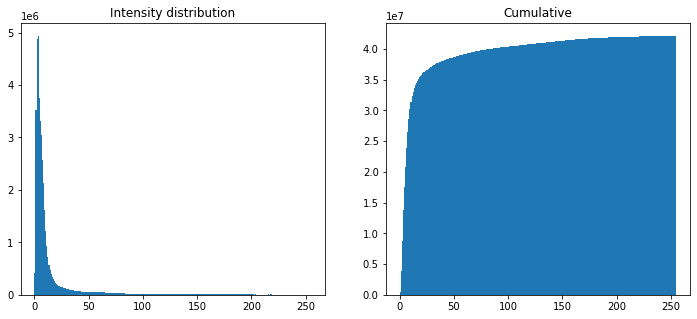

label distribution: 38242955 / 3871906 = 9.877


In [4]:
# get paths
prv_dir = lambda p: os.path.join("..", p)
files = os.listdir(prv_dir(infos['VOLUME']['input']))
fullpath = lambda dir, files : [os.path.join(dir, name) for name in files]
xs = fullpath(prv_dir(infos['VOLUME']['input'] ), files)
ys = fullpath(prv_dir(infos['VOLUME']['target']), files)

print("Dataset")
print("-nb of instances :", len(xs), "/", len(ys))

# open volumes
all_intensities = np.array([])
all_labels = np.array([])
print("Shape:")
for i in range(len(xs)):
    print(xs[i])
    x, y = tif.imread(xs[i]), tif.imread(ys[i])
    
    # combine body and cyto
    #y = np.stack([y[..., 0], np.logical_or(y[..., 1], y[..., 2])], axis=-1)
    y = np.logical_or(y[..., 1], y[..., 2])
    
    all_labels = np.concatenate([all_labels , y.flatten()], axis=0)

    # make uint8
    to_uint8 = lambda x: (x * 255).astype(np.uint8)
    x = to_uint8(x)
    
    all_intensities = np.concatenate([all_intensities, x.flatten()], axis=0)

    print("{}.{} {}".format(i, x.shape, y.shape))

    xs[i], ys[i] = x, y

plt.subplot(121)
plt.title("Intensity distribution")
plt.hist(all_intensities, bins=256)
plt.subplot(122)
plt.title("Cumulative")
plt.hist(all_intensities, bins=256, cumulative=1)
plt.show()

ncell = int(all_labels.sum())
nbg   = np.logical_not(all_labels).sum()
print("label distribution: {} / {} = {}".format(nbg, ncell, np.round(nbg/ncell, 3)))

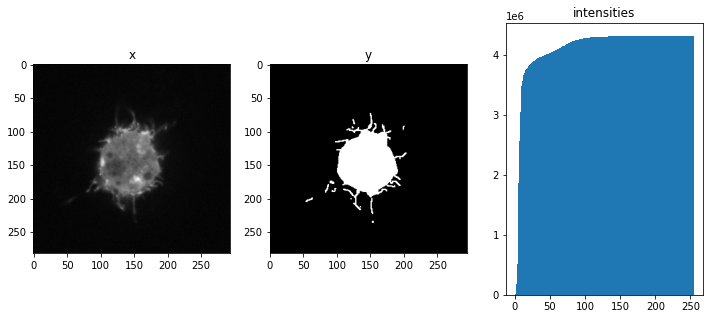

In [5]:
z = 15
i = 5
plt.subplot(131)
plt.title("x")
plt.imshow(xs[i][z])
plt.subplot(132)
plt.title("y")
plt.imshow(ys[i][z])
plt.subplot(133)
plt.title("intensities")
plt.hist(xs[i].flatten(), bins=256, cumulative=1)
plt.show()

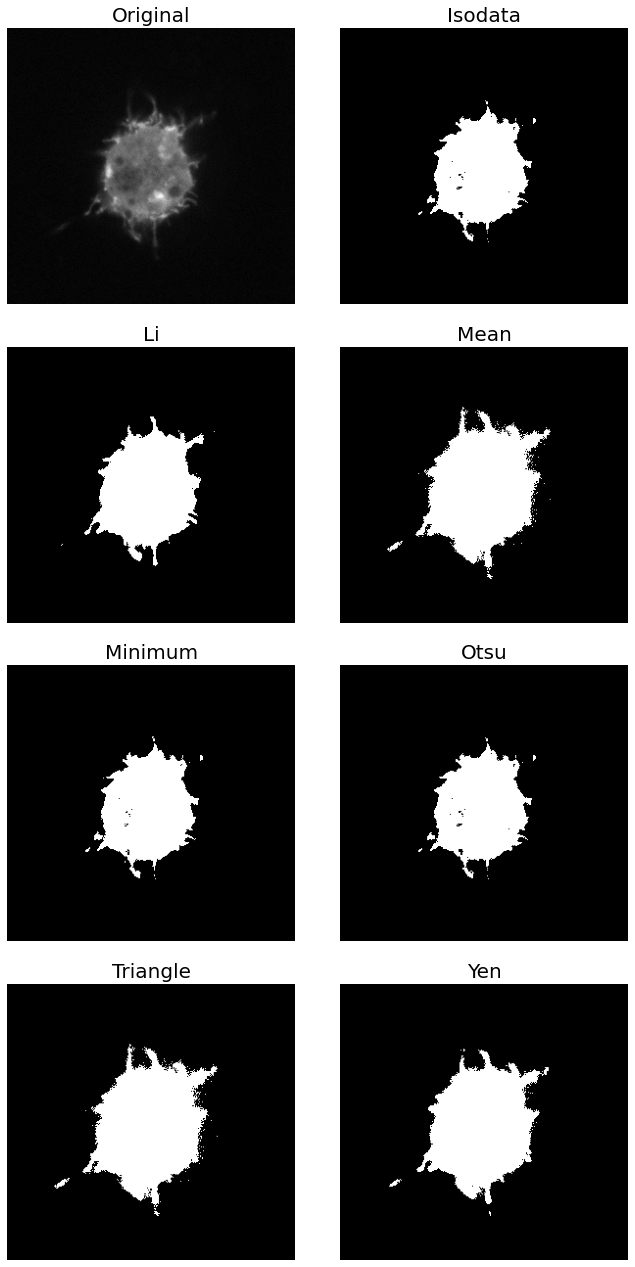

In [6]:
from skimage.filters import try_all_threshold
plt.rc('font', size=20) 
try_all_threshold(xs[i][z], figsize=(10,18), verbose=False)
plt.savefig("try_all_threshold.png")

## Denoising

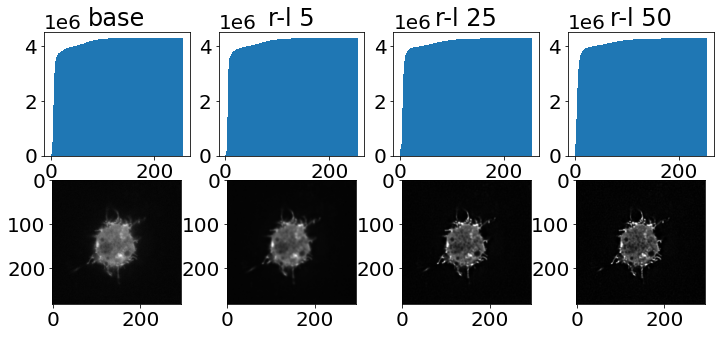

In [7]:
# richardson-lucy (must be in float)
to_float = lambda x: x.astype(float) / 255
psf = tif.imread(os.path.join(prv_dir(infos['DIR']['psf']), "Averaged PSF.tif"))
tmp1 = to_uint8(richardson_lucy(to_float(xs[i]), psf, iterations=5))
tmp2 = to_uint8(richardson_lucy(to_float(xs[i]), psf, iterations=25))
tmp3 = to_uint8(richardson_lucy(to_float(xs[i]), psf, iterations=50))

plt.subplot(241)
plt.title("base")
plt.hist(xs[i].flatten(), bins=256, cumulative=1)
plt.subplot(242)
plt.title("r-l 5")
plt.hist(tmp1.flatten(), bins=256, cumulative=1)
plt.subplot(243)
plt.title("r-l 25")
plt.hist(tmp2.flatten(), bins=256, cumulative=1)
plt.subplot(244)
plt.title("r-l 50")
plt.hist(tmp3.flatten(), bins=256, cumulative=1)

plt.subplot(245)
plt.imshow(xs[i][z])
plt.subplot(246)
plt.imshow(tmp1[z])
plt.subplot(247)
plt.imshow(tmp2[z])
plt.subplot(248)
plt.imshow(tmp3[z])

plt.show()

<ipython-input-8-ebb6b839454b>:13: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(0)


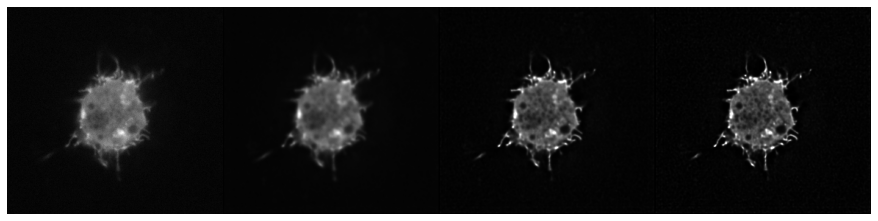

In [8]:
plt.subplot(141)
plt.axis("off")
plt.imshow(xs[i][z])
plt.subplot(142)
plt.axis("off")
plt.imshow(tmp1[z])
plt.subplot(143)
plt.axis("off")
plt.imshow(tmp2[z])
plt.subplot(144)
plt.axis("off")
plt.imshow(tmp3[z])
plt.tight_layout(0)
plt.savefig("richardson_lucy_ctrl1.png")
plt.show()

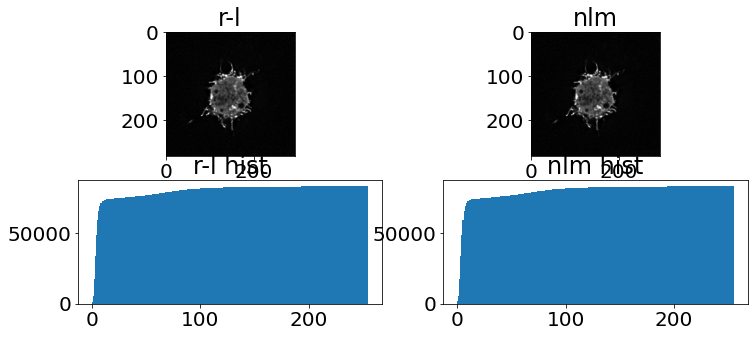

In [9]:
# non-local means (doesnt seem to worth it, especially if it takes 2 mins+)
sigma_est = estimate_sigma(tmp3)
nlm = denoise_nl_means(tmp3,
                       patch_size=7,
                       patch_distance=7,
                       h=0.8*sigma_est,  # recommend slightly less than standard deviation
                       sigma=sigma_est,
                       fast_mode=True,   # cost more memory
                       preserve_range=True)

plt.subplot(221)
plt.title("r-l")
plt.imshow(tmp3[z])
plt.subplot(222)
plt.title("nlm")
plt.imshow(nlm[z])
plt.subplot(223)
plt.title("r-l hist")
plt.hist(tmp3[z].flatten(), bins=256, cumulative=1)
plt.subplot(224)
plt.title("nlm hist")
plt.hist(nlm[z].flatten(), bins=256, cumulative=1)
plt.show()

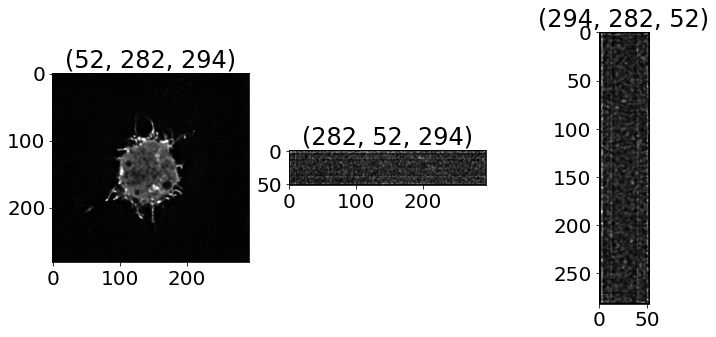

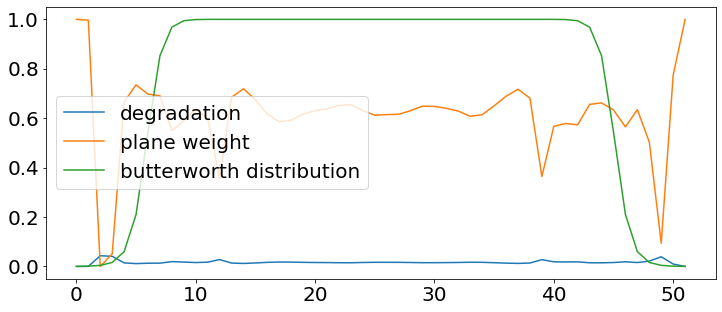

In [10]:
# reduce noise in axis Z limits
plt.subplot(131)
plt.title(str(tmp3.shape))
plt.imshow(tmp3[z])
plt.subplot(132)
rearranged_x = np.moveaxis(tmp3, [0], [1])
plt.title(str(rearranged_x.shape))
plt.imshow(rearranged_x[z])
plt.subplot(133)
rearranged_x2 = np.moveaxis(tmp3, [2, 0], [0, 2])
plt.title(str(rearranged_x2.shape))
plt.imshow(rearranged_x2[z])
plt.show()

def rearrange_volume(x):
    rearranged_x = np.moveaxis(x, [0], [1])
    rearranged_y = np.moveaxis(x, [2, 0], [0, 2])
    return rearranged_x, rearranged_y

def avg_degradation(x, y, r=0.2):
    axis_len = int(np.round(x.shape[1] * r))
    sort_nd = lambda x: x[tuple([np.argsort(x.sum(axis=0), axis=-1)])]

    # process x
    a = x.mean(axis=2)
    b = sort_nd(a)[:axis_len]
    dx = b.mean(axis=0)

    # process y
    a = y.mean(axis=1)
    b = sort_nd(a)[:axis_len]
    #b = a[tuple([np.argsort(a.sum(axis=0), axis=-1)])][:axis_len]
    dy = b.mean(axis=0)

    davg = np.mean(np.stack([dx, dy], axis=-1), axis=-1)
    return davg

rx, ry = rearrange_volume(tmp3)
d = avg_degradation(rx, ry, 0.25)
plt.plot(d / 255, label='degradation')
norm_d = d - d.min()
norm_d = norm_d / norm_d.max()
weight = 1 - norm_d
plt.plot(weight, label='plane weight')

# I prefer to make butterworth overkill to make it extra safe
def butterworth(n, low, high):
    u = np.linspace(0, n, n) # Position fréquence rows
    D = np.sqrt((u-n/2)**2)
    h = 1 / (1 + (D/low)**(2*high))
    return h

btw = butterworth(52, 20, 15)
plt.plot(btw, label='butterworth distribution')
plt.legend()
plt.show()

(52, 282, 294)


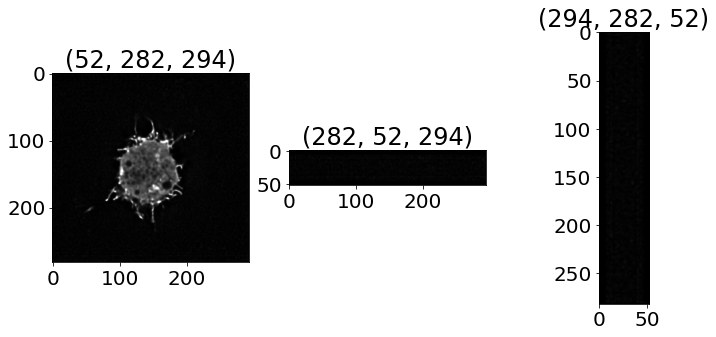

In [11]:
# apply weights over Z axis
weighted = tmp3 * btw[:, np.newaxis, np.newaxis]
print(weighted.shape)
plt.subplot(131)
plt.title(str(weighted.shape))
plt.imshow(weighted[z])
plt.subplot(132)
rearranged_x = np.moveaxis(weighted, [0], [1])
plt.title(str(rearranged_x.shape))
plt.imshow(rearranged_x[z], vmin=0, vmax=255)
plt.subplot(133)
rearranged_x2 = np.moveaxis(weighted, [2, 0], [0, 2])
plt.title(str(rearranged_x2.shape))
plt.imshow(rearranged_x2[z], vmin=0, vmax=255)
plt.show()

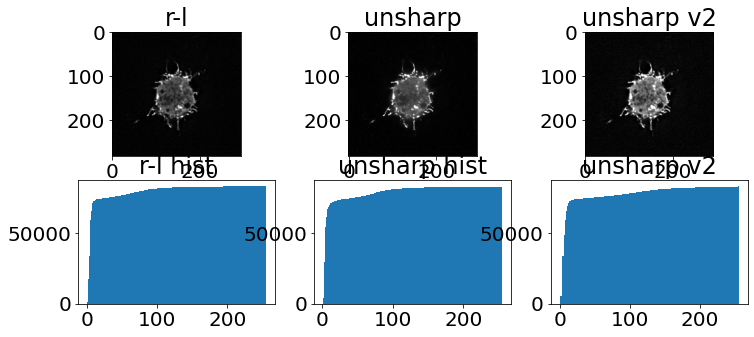

In [12]:
# unsharp filter
amount = 0.6
unsharp = np.clip(weighted + np.abs(weighted - nd.gaussian_filter(weighted, 4)) * amount, 0, 255)
#unsharp = to_uint8(unsharp / unsharp.max())

plt.subplot(231)
plt.title("r-l")
plt.imshow(weighted[z])
plt.subplot(232)
plt.title("unsharp")
plt.imshow(unsharp[z])
plt.subplot(234)
plt.title("r-l hist")
plt.hist(weighted[z].flatten(), bins=256, cumulative=1)
plt.subplot(235)
plt.title("unsharp hist")
plt.hist(unsharp[z].flatten(), bins=256, cumulative=1)

laplacian = np.maximum(
    nd.gaussian_filter(weighted, 1.5, 2),
    nd.gaussian_filter(weighted,   2, 2),
    nd.gaussian_filter(weighted,   4, 2)
)

details = np.abs(weighted - laplacian)
unsharp_v2 = np.clip(weighted + (details * amount), 0, 255)
#unsharp_v2 = to_uint8(unsharp_v2 / unsharp_v2.max())
plt.subplot(233)
plt.title("unsharp v2")
plt.imshow(unsharp_v2[z])
plt.subplot(236)
plt.title("unsharp v2")
plt.hist(unsharp_v2[z].flatten(), bins=256, cumulative=1)

plt.show()

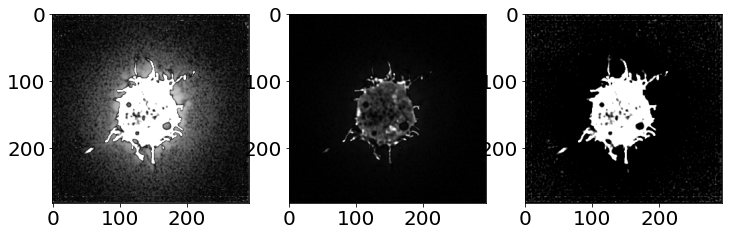

In [13]:
amount = 10
unsharp = weighted + np.abs(weighted - nd.gaussian_filter(weighted, 50)) * amount
plt.subplot(131)
plt.imshow(np.clip(unsharp[z], 0, 255))
plt.subplot(132)
plt.imshow(unsharp[z] / unsharp.max())
plt.subplot(133)
plt.imshow(skimage.filters.unsharp_mask(to_float(weighted), 50, amount=amount)[z])
plt.show()

# the best
unsharp = skimage.filters.unsharp_mask(to_float(weighted), 50, amount=amount)

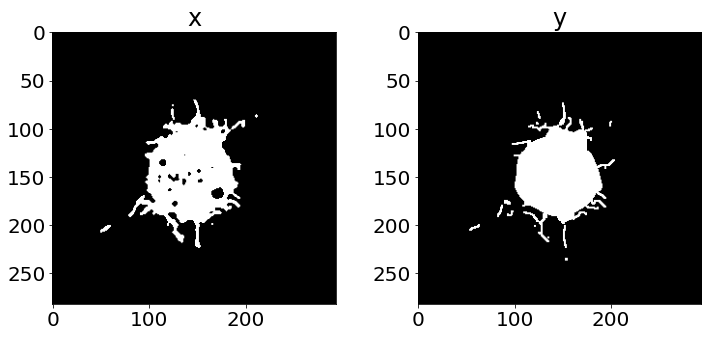

dice : 0.96914697
cldice : 0.8331875
dicecldice : 0.9011673


In [14]:
iters = 10
ndim  = 3
pad   = 2
dice       = mtc.Dice()
cldice     = mtc.ClDice(    iters=iters, ndim=ndim, mode=pad)
dicecldice = mtc.DiceClDice(iters=iters, ndim=ndim, mode=pad)
metrics = [m.coefficient for m in [dice, cldice, dicecldice]]
nd_to_tensor = lambda x: tf.convert_to_tensor(np.expand_dims(np.stack([np.logical_not(x), x], axis=-1), axis=0), dtype=tf.float32)

x_thresh = (nd.median_filter(unsharp, size=[1,3,3]) > filters['otsu'](unsharp)).astype(float)

def eval(x, y):
    x_tensor = nd_to_tensor(x.astype(float))
    y_tensor = nd_to_tensor(y.astype(float))

    plt.subplot(121)
    plt.title('x')
    plt.imshow(x[z])
    plt.subplot(122)
    plt.title('y')
    plt.imshow(y[z])
    plt.show()

    for m in metrics:
        print(m.__name__, ":", m(y_tensor, x_tensor).numpy())

eval(x_thresh, ys[i])

## Find labels

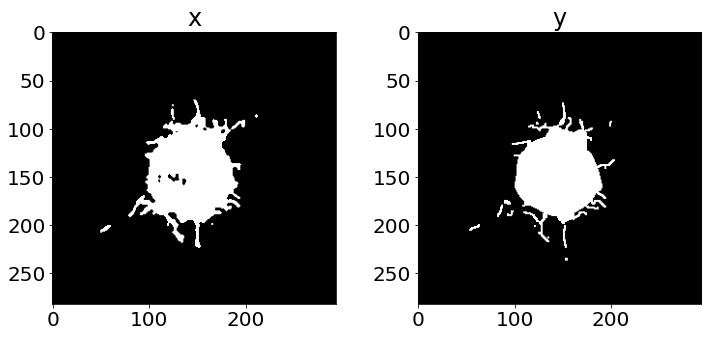

dice : 0.9697229
cldice : 0.825116
dicecldice : 0.89741945


In [15]:
# first rm useless regions
def get_small_obj(x, size, distances=[1,1,1]):
    lb = measure.label(x)
    px_superficie = np.prod(distances)
    rp = measure.regionprops(lb)
    y = np.zeros_like(x)
    min_px = size / px_superficie
    for p in rp:
        if p.area <= min_px:
            y[lb == p.label] = 1
    return y

s = 1000
cln = nd.morphology.binary_fill_holes(x_thresh)
cln = np.logical_and(cln, np.logical_not(get_small_obj(cln, s, distances=distances)))

eval(cln, ys[i])

## Identify cell bodies

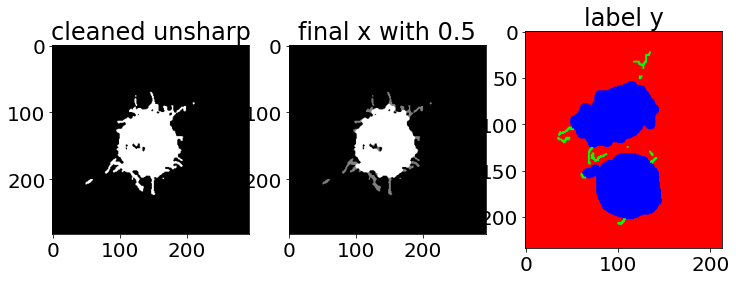

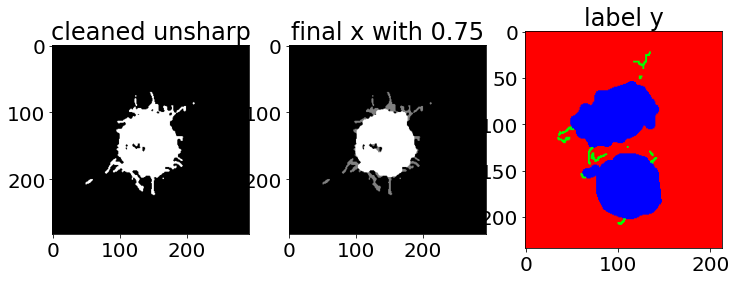

In [16]:
# separate cyto from body
def separate_cls(x, selem=None, distances=[1,1,1]):
    if selem is None:
        selem = carreno.utils.morphology.create_sphere(radius, distances)
    body = morphology.binary_opening(x, selem).astype(np.uint8)
    cyto = ((x - body) > 0).astype(np.uint8)
    return body * 2 + cyto

label_y = tif.imread(fullpath(prv_dir(infos['VOLUME']['target']), files)[0])
for r in [0.5, 0.75]:
    selem = carreno.utils.morphology.create_sphere(r, distances)
    #selem = np.expand_dims(np.amax(selem, axis=0), axis=0)  # disk instead of sphere
    cls = separate_cls(cln, selem, distances)
    
    plt.subplot(131)
    plt.title('cleaned unsharp')
    plt.imshow(cln[z])
    plt.subplot(132)
    plt.title('final x with {}'.format(r))
    plt.imshow(cls[z])
    plt.subplot(133)
    plt.title('label y')
    plt.imshow(label_y[z])
    plt.show()

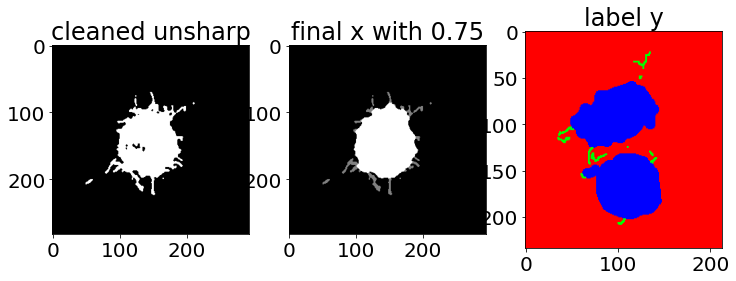

In [17]:
# correction attempt
def seperate_cls_w_closing(x, r1, r2, distances=[1,1,1]):
    sphere = carreno.utils.morphology.create_sphere(r1, distances)
    disk = np.expand_dims(np.amax(sphere, axis=0), axis=0)  # disk instead of sphere
    y = separate_cls(x, selem=disk, distances=distances)
    
    # fill bodies
    body = y == 2
    sphere = carreno.utils.morphology.create_sphere(r2, distances)
    y[morphology.binary_closing(body, selem=sphere)] = 2
    
    # try seperating classes again
    y = separate_cls(y > 0, selem=disk, distances=distances)

    return y

cls = seperate_cls_w_closing(cln, r1=0.5, r2=1, distances=distances)

plt.subplot(131)
plt.title('cleaned unsharp')
plt.imshow(cln[z])
plt.subplot(132)
plt.title('final x with {}'.format(0.75))
plt.imshow(cls[z])
plt.subplot(133)
plt.title('label y')
plt.imshow(label_y[z])
plt.show()

## Seperate cells
If 2 cells oare touching, we want to seperate them. Particularly an issue because of how blurry the depth can get.

In [18]:
#np.prod(distances) * 150000
600 / np.prod(distances)

159974.19806676486

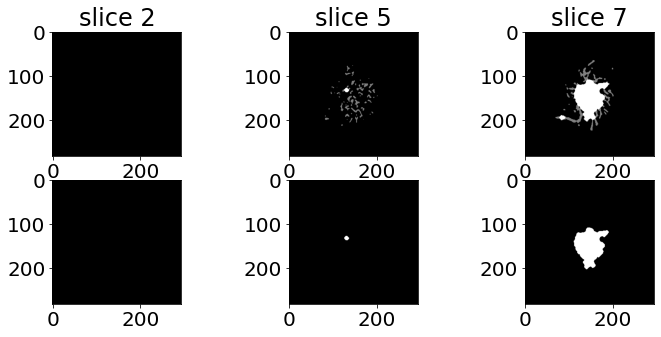

In [19]:
def seperate_blobs(x, min_dist=5, num_peaks=np.inf, distances=[1, 1, 1]):
    """Separate blobs using watershed. Seeds are found using the foreground pixels distance from background pixels.
    Parameters
    ----------
    x : list, ndarray
        binary mask of blobs
    min_dist : float
        minimum distance between seeds for watershed
    distances : list, ndarray
        axis distances in order
    Returns
    -------
    label : ndarray
        labelled blob
    """
    y = x.copy()

    # find 1 local max per blob
    distance = nd.distance_transform_edt(y)
    min_dist = int(min_dist / min(distances))
    
    coords = skimage.feature.peak_local_max(distance,
                                            min_distance=min_dist,
                                            num_peaks=num_peaks,
                                            labels=y)
    
    # seperate the cells
    local_max = np.zeros(distance.shape, dtype=bool)
    local_max[tuple(coords.T)] = True
    markers = nd.label(local_max)[0]
    label = skimage.segmentation.watershed(-distance, markers, mask=y)

    return label

# without weighted Z axis, labels are all fuzed on slice 2
plt.subplot(231)
plt.title("slice 2")
plt.imshow(cls[2])
plt.subplot(232)
plt.title("slice 5")
plt.imshow(cls[5])
plt.subplot(233)
plt.title("slice 7")
plt.imshow(cls[7])

n_peaks = int((cls == 2).sum() // (500 / np.prod(distances)))
bodies = seperate_blobs(cls == 2, min_dist=3, num_peaks=n_peaks, distances=distances)

plt.subplot(234)
plt.imshow(bodies[2])
plt.subplot(235)
plt.imshow(bodies[5])
plt.subplot(236)
plt.imshow(bodies[7])

plt.show()

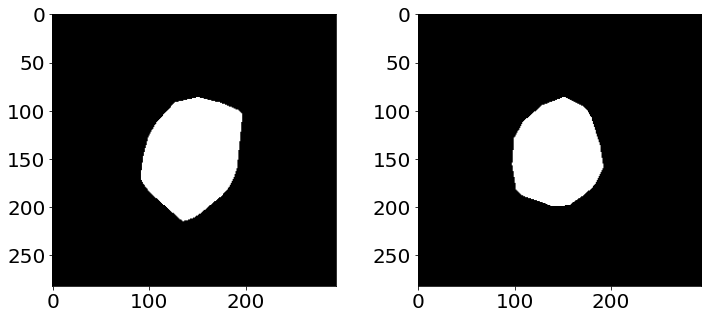

In [20]:
# if the segmentation of bodies is too hard to fill, convex hull is an option...
import scipy
def flood_fill_hull(image):
    # taken from https://stackoverflow.com/questions/46310603/how-to-compute-convex-hull-image-volume-in-3d-numpy-arrays
    points = np.transpose(np.where(image))

    if len(points) == 0:
        return np.zeros_like(image), None
    
    hull = scipy.spatial.ConvexHull(points)
    deln = scipy.spatial.Delaunay(points[hull.vertices]) 
    idx = np.stack(np.indices(image.shape), axis = -1)
    out_idx = np.nonzero(deln.find_simplex(idx) + 1)
    out_img = np.zeros(image.shape)
    out_img[out_idx] = 1
    
    return out_img.astype(bool), hull

# convex hull in 3D
smooth = bodies.copy()
for lb in range(1, bodies.max()+1):
    body, _ = flood_fill_hull((bodies == lb))
    smooth[body] = lb

# convex hull in 2D because of the blur
smooth_v2 = bodies.copy()
for lb in range(1, bodies.max()+1):
    body = np.array([flood_fill_hull((bodies[i] == lb))[0] for i in range(bodies.shape[0])])
    smooth_v2[body] = lb

plt.subplot(121)
plt.imshow(smooth[z])
plt.subplot(122)
plt.imshow(smooth_v2[z])

plt.show()

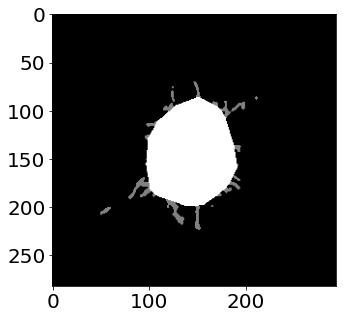

In [21]:
# update classes with smoothed bodies
cls[smooth_v2 > 0] = 2

plt.imshow(cls[z])
plt.show()

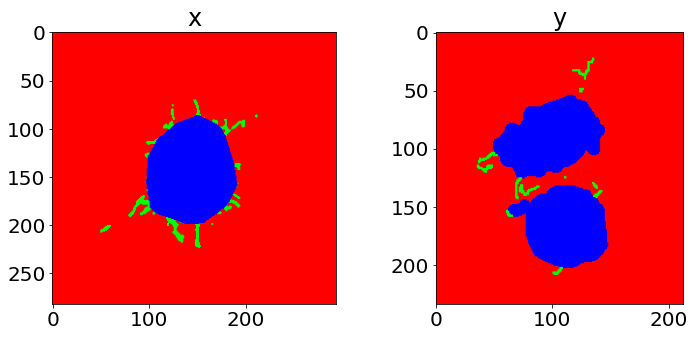

InvalidArgumentError: required broadcastable shapes [Op:Mul]

In [22]:
def sparse_to_categorical(x):
    cls = []
    for i in range(x.min(), x.max()+1):
        cls.append(x == i)
    return np.stack(cls, axis=-1).astype(float)

nd_to_tensor = lambda x: tf.convert_to_tensor(np.expand_dims(x, axis=0), dtype=tf.float32)
final_x = sparse_to_categorical(cls)

eval(final_x, label_y)

### Extra
Example why simply averaging axis with a ratio of 100% is a bad idea to guess the degradation on Z. We would punish the cells heavily.

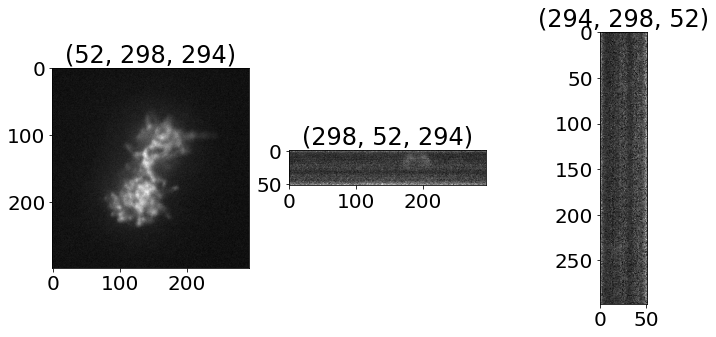

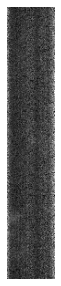

In [24]:
def axis_views(x):
    return x, np.moveaxis(x, [0], [1]), np.moveaxis(x, [2, 0], [0, 2])

x = xs[4]
top, side1, side2 = axis_views(x)

plt.subplot(131)
plt.title(str(top.shape))
plt.imshow(top[0])
plt.subplot(132)
plt.title(str(side1.shape))
plt.imshow(side1[0])
plt.subplot(133)
plt.title(str(side2.shape))
plt.imshow(side2[0])
plt.show()

plt.imshow(side2[10])
plt.axis('off')
plt.savefig("Slik1_h10.png")
plt.show()

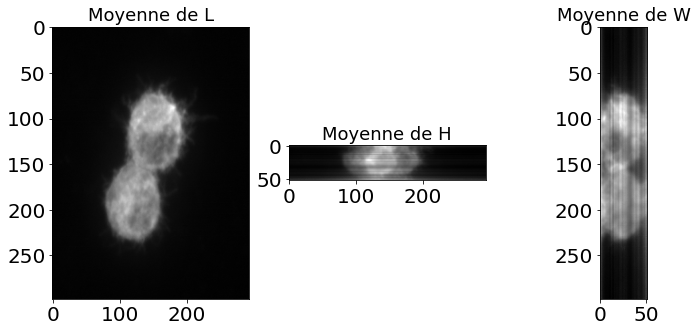

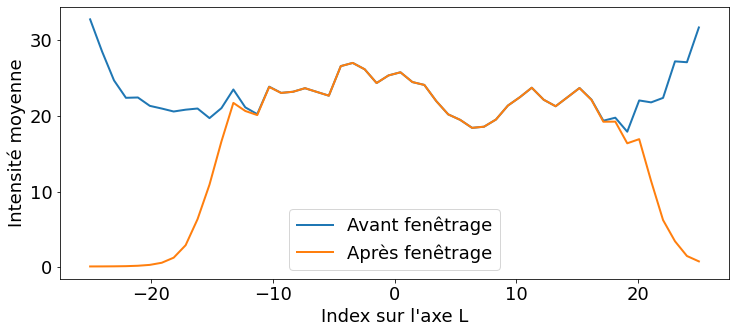

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title("Moyenne de L", fontsize=18)
ax1.imshow(top.mean(axis=0))
ax1.set_aspect("auto")

ax2.set_title("Moyenne de H", fontsize=18)
ax2.imshow(side1.mean(axis=0))
ax2.set_aspect(1)

ax3.set_title("Moyenne de W", fontsize=18)
ax3.imshow(side2.mean(axis=0))
ax3.set_aspect(1)

#plt.subplot(131)
#plt.title("Moyenne de L")
#plt.imshow(top.mean(axis=0))
#plt.subplot(132)
#plt.title("Moyenne de H")
#plt.imshow(side1.mean(axis=0))
#plt.subplot(133)
#plt.title("Moyenne de W")
#plt.imshow(side2.mean(axis=0)); plt.show()
plt.savefig("slik1_avg.png")
plt.show()

#plt.plot(np.linspace(-25, 25, 52), side1.mean(axis=0).mean(axis=1), label='Axe H', linewidth=2)
plt.plot(np.linspace(-25, 25, 52), side2.mean(axis=0).mean(axis=0)+0.1, label='Avant fenêtrage', linewidth=2)
plt.plot(np.linspace(-25, 25, 52), btw*side2.mean(axis=0).mean(axis=0)+0.1, label='Après fenêtrage', linewidth=2)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel("Index sur l'axe L", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Intensité moyenne", fontsize=18)
plt.savefig("btw_ex.png")
plt.show()

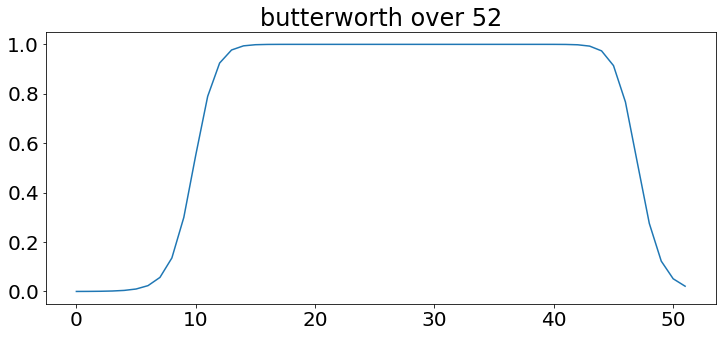

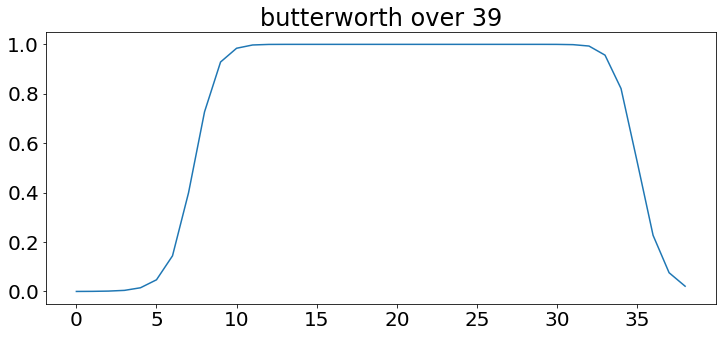

In [30]:
def butterworth(n, low, high, shift=0):
    """
    Butterworth distribution in 1D
    Parameters
    ----------
    n : int
        length of the distribution
    low : float
        low values boundaries
    high : float
        high values boundaries
    Returns
    -------
    n : ndarray
        distribution values in a list
    """
    u = np.linspace(0-shift, n-shift, n)
    D = np.sqrt((u-n/2)**2)
    h = 1 / (1 + (D/low)**(2*high))
    return h

# weight the first axis to ignore blurs
btw = butterworth(52, 19, 10, 3)
plt.plot(btw); plt.title("butterworth over 52"); plt.show()
plt.plot(scipy.interpolate.interp1d(np.linspace(0, 51, 52), btw)(np.linspace(0, 51, 39))); plt.title("butterworth over 39"); plt.show()